In [1]:
from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

# colmap_path = "/Users/derek/Desktop/colmap/360_extra_scenes/treehill/sparse/0"
colmap_path = "/home/da2986/personal_gaussian_splatting/treehill/sparse/0"

reconstruction = pycolmap.Reconstruction(colmap_path)
test = False

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
image_num = 100

for idx, point in enumerate(points3d.values()):
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)
        
image = images[image_num]
points_in_3d = []
points2d = []
colors2d = []
for idx, point in enumerate(image.xys):
    point3d_id = image.point3D_ids[idx]
    if point3d_id > 0:
        try:
            color = points3d[point3d_id].color
            points_in_3d.append(points3d[point3d_id].xyz)
            points2d.append(point)
            colors2d.append(color)
        except:
            pass
        
all_points3d = np.array(all_points3d)
all_point_colors = np.array(all_point_colors)
points_in_3d = np.array(points_in_3d)
points2d = np.array(points2d)
colors2d = np.array(colors2d)

print(all_points3d.shape, points_in_3d.shape)
gaussians = Gaussians(
    torch.Tensor(all_points3d), 
    torch.Tensor(all_point_colors),
    model_path="point_clouds"
)

(52363, 3) (1697, 3)
initialized_points


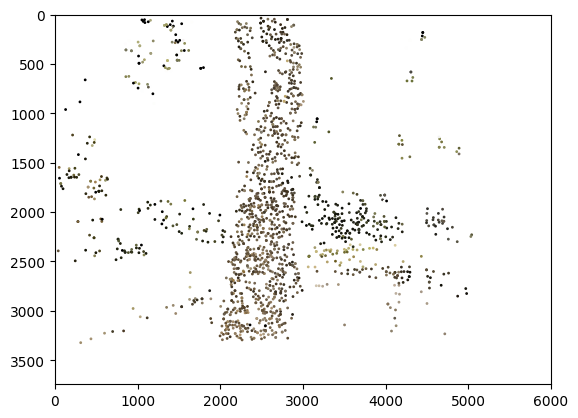

In [2]:
import matplotlib.pyplot as plt

scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

In [3]:
cuda_src = """
#include <cstdio>
#include <cmath> // Include this header for expf function
#include <torch/extension.h>

__device__ float compute_pixel_strength(
    int pixel_x,
    int pixel_y,
    int point_x,
    int point_y,
    float inverse_covariance_a,
    float inverse_covariance_b,
    float inverse_covariance_c)
{
    // Compute the distance between the pixel and the point
    float dx = pixel_x - point_x;
    float dy = pixel_y - point_y;
    float power = dx * inverse_covariance_a * dx + 2 * dx * dy * inverse_covariance_b + dy * dy * inverse_covariance_c;
    return expf(-0.5f * power);
}

__global__ void render_tile(
    int image_height,
    int image_width,
    int tile_size,
    int num_points,
    float *point_means,
    float *point_colors,
    float *image,
    float *inverse_covariance_2d,
    float *min_x,
    float *max_x,
    float *min_y,
    float *max_y,
    float *opacity)
{
    // Calculate the pixel's position in the image
    int pixel_x = blockIdx.x * tile_size + threadIdx.x;
    int pixel_y = blockIdx.y * tile_size + threadIdx.y;

    // Ensure the pixel is within the image bounds
    if (pixel_x >= image_width || pixel_y >= image_height)
    {
        return;
    }

    float total_weight = 1.0f;
    float3 color = {0.0f, 0.0f, 0.0f};

    for (int i = 0; i < num_points; i++)
    {
        float point_x = point_means[i * 2];
        float point_y = point_means[i * 2 + 1];

        // checks to make sure we are within the bounding box
        bool x_check = pixel_x >= min_x[i] && pixel_x <= max_x[i];
        bool y_check = pixel_y >= min_y[i] && pixel_y <= max_y[i];
        if (!x_check || !y_check)
        {
            continue;
        }
        float strength = compute_pixel_strength(
            pixel_x,
            pixel_y,
            point_x,
            point_y,
            inverse_covariance_2d[i * 4],
            inverse_covariance_2d[i * 4 + 1],
            inverse_covariance_2d[i * 4 + 3]);
        
        float alpha = opacity[i] * strength;
        float test_weight = total_weight * (1 - alpha);
        if (test_weight < 0.001f)
        {
            break;
        }
        color.x += total_weight * alpha * point_colors[i * 3];
        color.y += total_weight * alpha * point_colors[i * 3 + 1];
        color.z += total_weight * alpha * point_colors[i * 3 + 2];
        total_weight = test_weight;
    }

    image[(pixel_y * image_width + pixel_x) * 3] = color.x;
    image[(pixel_y * image_width + pixel_x) * 3 + 1] = color.y;
    image[(pixel_y * image_width + pixel_x) * 3 + 2] = color.z;

}


torch::Tensor render_image(
    int image_height,
    int image_width,
    int tile_size,
    torch::Tensor point_means,
    torch::Tensor point_colors,
    torch::Tensor inverse_covariance_2d,
    torch::Tensor min_x,
    torch::Tensor max_x,
    torch::Tensor min_y,
    torch::Tensor max_y,
    torch::Tensor opacity)
{
    // Ensure the input tensors are on the same device
    torch::TensorArg point_means_t{point_means, "point_means", 1},
        point_colors_t{point_colors, "point_colors", 2},
        inverse_covariance_2d_t{inverse_covariance_2d, "inverse_covariance_2d", 3},
        min_x_t{min_x, "min_x", 4},
        max_x_t{max_x, "max_x", 5},
        min_y_t{min_y, "min_y", 6},
        max_y_t{max_y, "max_y", 7},
        opacity_t{opacity, "opacity", 8};
    torch::checkAllSameGPU("render_image", {point_means_t, point_colors_t, inverse_covariance_2d_t, min_x_t, max_x_t, min_y_t, max_y_t, opacity_t});

    
    // Create an output tensor for the image
    torch::Tensor image = torch::zeros({image_height, image_width, 3}, point_means.options());

    // Calculate the number of tiles in the image
    int num_tiles_x = (image_width + tile_size - 1) / tile_size;
    int num_tiles_y = (image_height + tile_size - 1) / tile_size;

    // Launch a CUDA kernel to render the image
    dim3 block(tile_size, tile_size);
    dim3 grid(num_tiles_x, num_tiles_y);
    render_tile<<<grid, block>>>(
        image_height,
        image_width,
        tile_size,
        point_means.size(0),
        point_means.data_ptr<float>(),
        point_colors.data_ptr<float>(),
        image.data_ptr<float>(),
        inverse_covariance_2d.data_ptr<float>(),
        min_x.data_ptr<float>(),
        max_x.data_ptr<float>(),
        min_y.data_ptr<float>(),
        max_y.data_ptr<float>(),
        opacity.data_ptr<float>());

    return image;
}
"""



cpp_src = """
torch::Tensor render_image(
    int image_height,
    int image_width,
    int tile_size,
    torch::Tensor point_means,
    torch::Tensor point_colors,
    torch::Tensor inverse_covariance_2d,
    torch::Tensor min_x,
    torch::Tensor max_x,
    torch::Tensor min_y,
    torch::Tensor max_y,
    torch::Tensor opacity);
"""

In [4]:
import os

from torch.utils.cpp_extension import load_inline

os.environ['CUDA_LAUNCH_BLOCKING']='1'

def load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=False):
    return load_inline(
        name="inline_ext",
        cpp_sources=[cpp_src],
        cuda_sources=[cuda_src],
        functions=funcs,
        extra_cuda_cflags=["-O1"] if opt else [],
        verbose=verbose
    )

# Set MAX_JOBS for parallel compilation
os.environ['MAX_JOBS'] = '10'

# Compile and load the CUDA module
module = load_cuda(cuda_src, cpp_src, ["render_image"], opt=True, verbose=True)

Using /home/da2986/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/da2986/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Using envvar MAX_JOBS (10) as the number of workers...


[1/2] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/da2986/.cache/pypoetry/virtualenvs/splat-xNgzlgcq-py3.10/lib/python3.10/site-packages/torch/include -isystem /home/da2986/.cache/pypoetry/virtualenvs/splat-xNgzlgcq-py3.10/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/da2986/.cache/pypoetry/virtualenvs/splat-xNgzlgcq-py3.10/lib/python3.10/site-packages/torch/include/TH -isystem /home/da2986/.cache/pypoetry/virtualenvs/splat-xNgzlgcq-py3.10/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /opt/conda/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed

Loading extension module inline_ext...


In [5]:
import os

image = scene.render_image_cuda(image_num, module, tile_size=16)

RuntimeError: CUDA error: an illegal memory access was encountered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


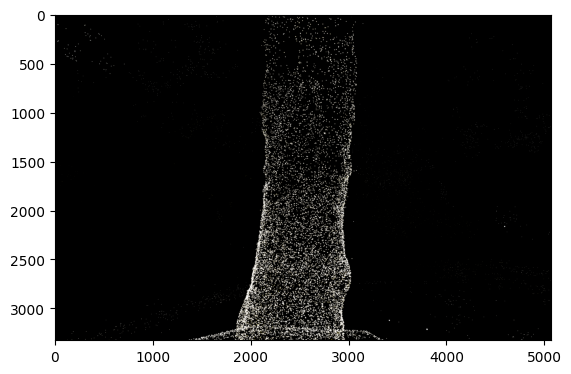

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(image.detach().cpu() * 256)